In [3]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet.utilities import regressor_coefficients
from flore_modeling import create_forecast

import pickle


In [4]:
df = pd.read_csv('df_inno_flore1.csv', sep=',')
df = df.fillna(0)

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

<Axes: xlabel='Date'>

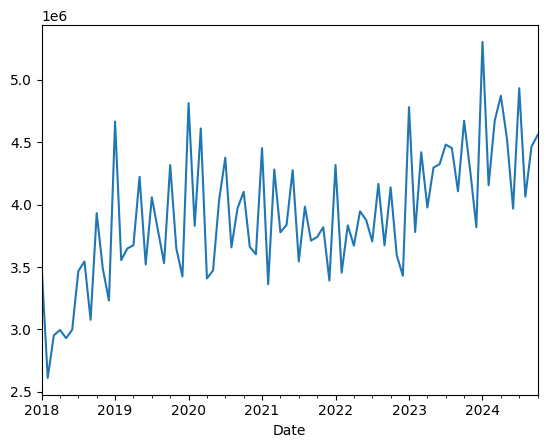

In [6]:
df.set_index('Date')['Ex-factory volumes'].plot()

**Why Remove Collinearity in Time Series Forecasting?**  

- **Improves model stability**: Prevents unstable or unreliable coefficients.  
- **Enhances prediction accuracy**: Reduces overfitting and improves generalization.  
- **Increases interpretability**: Clarifies the impact of each regressor.  
- **Avoids redundancy**: Removes unnecessary or duplicate information.  
- **Boosts efficiency**: Simplifies the model and reduces computational complexity.  

In [7]:
df.columns

Index(['Date', 'INNOVIX_Indication 10_Email',
       'INNOVIX_Indication 10_Face to face call',
       'INNOVIX_Indication 10_Meetings', 'INNOVIX_Indication 10_Remote call',
       'INNOVIX_Indication 12_Email',
       'INNOVIX_Indication 12_Face to face call',
       'INNOVIX_Indication 12_Meetings', 'INNOVIX_Indication 12_Remote call',
       'INNOVIX_Indication 19_Email',
       'INNOVIX_Indication 19_Face to face call',
       'INNOVIX_Indication 19_Meetings', 'INNOVIX_Indication 19_Remote call',
       'INNOVIX_Indication 1_Email', 'INNOVIX_Indication 1_Face to face call',
       'INNOVIX_Indication 1_Meetings', 'INNOVIX_Indication 1_Remote call',
       'INNOVIX_Indication 23_Email',
       'INNOVIX_Indication 23_Face to face call',
       'INNOVIX_Indication 23_Meetings', 'INNOVIX_Indication 23_Remote call',
       'INNOVIX_Indication 2_Email', 'INNOVIX_Indication 2_Face to face call',
       'INNOVIX_Indication 2_Meetings', 'INNOVIX_Indication 2_Remote call',
       'INNOVIX_Mi

In [ ]:
# Filtra i regressori
regressors = [col for col in df.columns if col not in ['Data', 'Ex-factory volumes']]


Original Regressors: 89
Filtered Regressors: 13
Deleted Regressors: {'INNOVIX_Indication 14_Indication 14_Indication split', 'INNOVIX_Indication 2_Meetings', 'INNOVIX_Milligrams', 'YREX_Indication 19', 'YREX_Indication 10_Indication 10_New patient share', 'YREX_Indication 19_Indication 19-c_Indication split', 'INNOVIX_Indication 2_Indication 2-a_New patient share', 'YREX_Indication 2_Indication 2-a_Indication split', 'YREX_Indication 20_Indication 20_Indication split', 'INNOVIX_Indication 2_Indication 2-c_New patient share', 'YREX_Indication 23_Indication 23_Indication split', 'INNOVIX_Indication 19_Indication 19-a_New patient share', 'YREX_Indication 5_Indication 5_Indication split', 'YREX_Indication 12', 'INNOVIX_Indication 1_Indication 1-a_New patient share', 'YREX_Indication 19_Indication 19-b_Indication split', 'YREX_Indication 23', 'INNOVIX_Indication 20_Indication 20_Indication split', 'YREX_Indication 9_Indication 9_New patient share', 'INNOVIX_Indication 10_Indication 10_New p

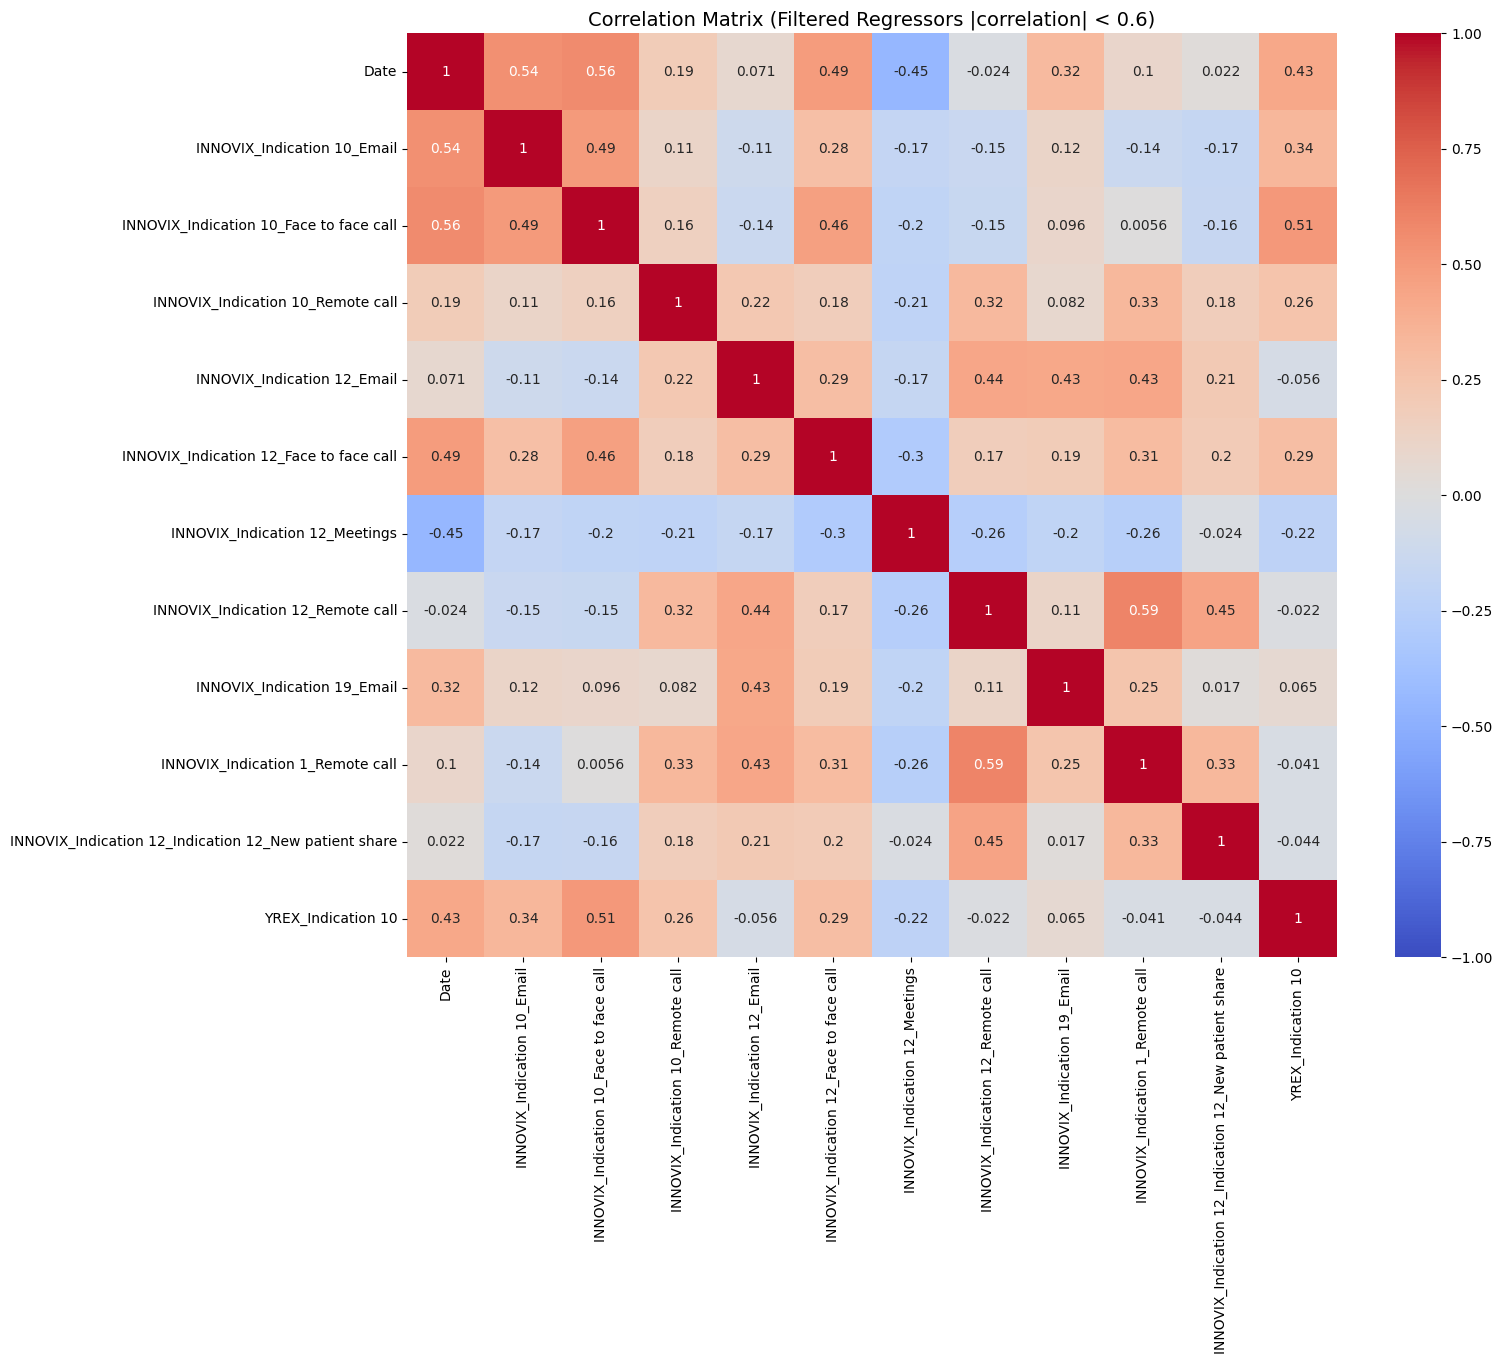

In [17]:
corr_matrix = df[regressors].corr()

correlated_features = set()
threshold = 0.6

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)


regressors_filtered = [col for col in regressors if col not in correlated_features]

print(f"Original Regressors: {len(regressors)}")
print(f"Filtered Regressors: {len(regressors_filtered)}")
print(f"Deleted Regressors: {correlated_features}")


filtered_corr = df[regressors_filtered].corr()
filtered_corr = filtered_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)


plt.figure(figsize=(15, 12))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Correlation Matrix (Filtered Regressors |correlation| < 0.6)', fontsize=14)
plt.show()


In [10]:
regressors_filtered = ['INNOVIX_Indication 10_Email',
 'INNOVIX_Indication 10_Face to face call',
 'INNOVIX_Indication 10_Remote call',
 'INNOVIX_Indication 12_Email',
 'INNOVIX_Indication 12_Face to face call',
 'INNOVIX_Indication 12_Meetings',
 'INNOVIX_Indication 12_Remote call',
 'INNOVIX_Indication 19_Email',
 'INNOVIX_Indication 1_Remote call',
 'INNOVIX_Indication 12_Indication 12_New patient share',
 'INNOVIX_Indication 2_Indication 2-b_New patient share',
 'YREX_Indication 10']

### COEFFICIENTS 

1. **Positive Impact: Regressors with Positive Coefficients**  
   Some regressors have a positive influence on the target variable. For these regressors, as their values increase, the predicted value of the target variable also increases.  
   **Examples:**  
   - `INNOVIX_Indication 12_Email` and `YREX_Indication 10` are notable contributors, indicating a direct positive impact on the outcome.  
   - `INNOVIX_Indication 12_Meetings` exhibits a very high positive impact, suggesting it could be a key driver of the target variable.

2. **Negative Impact: Regressors with Negative Coefficients**  
   These regressors reduce the predicted value of the target variable. A higher value for these regressors results in a decrease in the outcome.  
   **Examples:**  
   - `INNOVIX_Indication 10_Remote call` and `INNOVIX_Indication 1_Remote call` show significant negative effects.  
   - `INNOVIX_Indication 12_Face to face call` also has a negative impact, though to a lesser extent compared to others.

3. **Magnitude of Coefficients: High Magnitude Coefficients**  
   Some regressors have exceptionally high absolute coefficients, indicating that even small changes in their values can significantly impact the target variable.  
   **Examples:**  
   - `INNOVIX_Indication 12_Indication 12_New patient` has a very high positive coefficient, suggesting it is one of the most critical drivers.  
   - `INNOVIX_Indication 10_Email` also has a large positive coefficient, reinforcing its importance in the model.


In [19]:
#Reload the model
with open('prophet_model.pkl', 'rb') as f:
    m = pickle.load(f)

coefficients = regressor_coefficients(m)
coefficients


,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,INNOVIX_Indication 10_Email,additive,3.923077,6.505690e+03,6.505690e+03,6.505690e+03
1,INNOVIX_Indication 10_Face to face call,additive,82.038462,-5.804437e+01,-5.804437e+01,-5.804437e+01
2,INNOVIX_Indication 10_Remote call,additive,22.261538,-9.165672e+02,-9.165672e+02,-9.165672e+02
3,INNOVIX_Indication 12_Email,additive,5.046154,2.960313e+02,2.960313e+02,2.960313e+02
4,INNOVIX_Indication 12_Face to face call,additive,107.284615,-4.108273e+02,-4.108273e+02,-4.108273e+02
5,INNOVIX_Indication 12_Meetings,additive,3.076923,2.387101e+04,2.387101e+04,2.387101e+04
6,INNOVIX_Indication 12_Remote call,additive,64.146154,7.945313e+02,7.945313e+02,7.945313e+02
7,INNOVIX_Indication 19_Email,additive,23.738462,4.182203e+02,4.182203e+02,4.182203e+02
8,INNOVIX_Indication 1_Remote call,additive,42.876923,-1.127142e+03,-1.127142e+03,-1.127142e+03
9,INNOVIX_Indication 12_Indication 12_New patien...,additive,0.203244,1.624931e+06,1.624931e+06,1.624931e+06


In [ ]:
forecast, forecast_complete = create_forecast(m, regressors_filtered, "2025-12-01", "2027-12-01")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

           ds          yhat    yhat_lower    yhat_upper
0  2025-12-01  3.746414e+06  3.398633e+06  4.072473e+06
1  2026-01-01  4.598304e+06  4.284060e+06  4.923535e+06
2  2026-02-01  3.490436e+06  3.167354e+06  3.845705e+06
3  2026-03-01  3.985120e+06  3.650970e+06  4.319635e+06
4  2026-04-01  3.683174e+06  3.337457e+06  3.987457e+06
5  2026-05-01  3.983439e+06  3.635851e+06  4.339203e+06
6  2026-06-01  3.924098e+06  3.602633e+06  4.237387e+06
7  2026-07-01  4.073090e+06  3.746865e+06  4.412244e+06
8  2026-08-01  4.222262e+06  3.914149e+06  4.522017e+06
9  2026-09-01  3.841214e+06  3.528688e+06  4.171284e+06
10 2026-10-01  4.396300e+06  4.072907e+06  4.720041e+06
11 2026-11-01  3.776534e+06  3.418761e+06  4.107764e+06
12 2026-12-01  3.717274e+06  3.354195e+06  4.024581e+06
13 2027-01-01  4.895252e+06  4.525359e+06  5.218293e+06
14 2027-02-01  3.721952e+06  3.408569e+06  4.035969e+06
15 2027-03-01  3.747554e+06  3.438378e+06  4.076228e+06
16 2027-04-01  3.945810e+06  3.618194e+06  4.267